# Single-photon Simulation
- The following notebook demonstrates the use of the emulator to simulate the propagation of a single photon in a quantum photonic processor.
- This can be used to find the unitary implemented by a system.
- First import required modules and some additional tools.

In [1]:
from collections import Counter

import matplotlib.pyplot as plt

import lightworks as lw
from lightworks import State, emulator

- A general N is then defined, which is used to adjust the number of modes used for the circuit throughout the notebook.

In [2]:
N = 8

- Can then create a random unitary matrix which is programmed onto the chip.

In [3]:
U = lw.random_unitary(N)

circuit = lw.Unitary(U)

## Simulator
- First we try using the simulation part of the emulator. This allows the simulation of a number of input states, finding the probability amplitudes for the given outputs.
- To set this up, we specify the generated circuit to the simulator class. 

In [4]:
sim = emulator.Simulator(circuit)

- In this case we will choose to try to recreate the unitary matrix, which can be done by creating a list of all single photon input and output states.

In [5]:
states = []

# Create all single photon states by adding 1 to list when i=j, otherwise add 0
for i in range(N):
    state = []
    for j in range(N):
        if i == j:
            state += [1]
        else:
            state += [0]
    states.append(State(state))

# Calculate probability amplitude
results = sim.simulate(states, states)
U_calc = results.array

- The resultant matrix probability amplitude matrix can be visualized below, and we see that the unitary is correctly replicated.
- Note that the unitary needs to be transposed for the plotting below to show identical matrices.

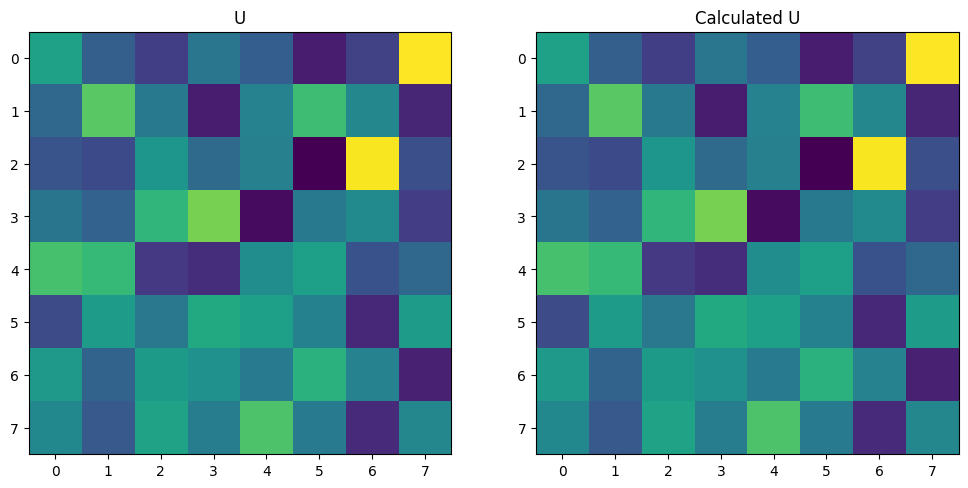

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(abs(U.T))
ax[1].imshow(abs(U_calc))
ax[0].set_title("U")
ax[1].set_title("Calculated U")

plt.show()

- It is also possible to directly view the probability amplitudes in a nicer form using the display_as_dataframe function included with the results object. 
- In this case the values are converted to probabilities with the conv_to_probability keyword.

In [7]:
results.display_as_dataframe(conv_to_probability=True)

,"|1,0,0,0,0,0,0,0>","|0,1,0,0,0,0,0,0>","|0,0,1,0,0,0,0,0>","|0,0,0,1,0,0,0,0>","|0,0,0,0,1,0,0,0>","|0,0,0,0,0,1,0,0>","|0,0,0,0,0,0,1,0>","|0,0,0,0,0,0,0,1>"
"|1,0,0,0,0,0,0,0>",0.187880,0.055688,0.023124,0.092186,0.054290,0.005508,0.024950,0.556373
"|0,1,0,0,0,0,0,0>",0.068229,0.311029,0.097022,0.005456,0.115826,0.269172,0.124379,0.008887
"|0,0,1,0,0,0,0,0>",0.042174,0.032456,0.160419,0.071796,0.111370,0.000249,0.543947,0.037589
"|0,0,0,1,0,0,0,0>",0.089451,0.060069,0.245367,0.353947,0.001352,0.097540,0.130642,0.021633
"|0,0,0,0,1,0,0,0>",0.283446,0.254240,0.019136,0.012586,0.139484,0.183564,0.039799,0.067746
"|0,0,0,0,0,1,0,0>",0.033732,0.176289,0.094476,0.212093,0.183445,0.113941,0.009779,0.176245
"|0,0,0,0,0,0,1,0>",0.168293,0.061512,0.170333,0.147343,0.099184,0.231435,0.115118,0.006782
"|0,0,0,0,0,0,0,1>",0.126795,0.048718,0.190123,0.104593,0.295049,0.098589,0.011388,0.124745


## Sampler
- The other way to use the emulator is as a sampler.
- This is achieved using the Sampler class, to which we provide the generated circuit and single input state that we want to look at. In this case we input a single photon on mode 0.

In [8]:
sampler = emulator.Sampler(circuit, State([1] + [0] * (N - 1)))

- Once the sampler has been set up, we can then sample from it many times.
- The probability distribution was pre-calculated in the last step, so the sampling procedure takes place very quickly.
- We get the output state from the sample, and convert this into a mode number which is stored.

In [9]:
N_rep = 100  # Set number of samples
results = []

for _ in range(N_rep):
    state = sampler.sample()
    # Get state from sampler and find which more the photon is on
    loc = state.s.index(1)
    results.append(loc)

# Count number of times we measure a photon on each mode
counted = Counter(results)

- The counts can then be converted into probabilities and compared to the expected values from the unitary.
- As we only choose to look at 100 samples here, the measured and expected distributions tend to vary as not enough samples have been taken to see convergence.

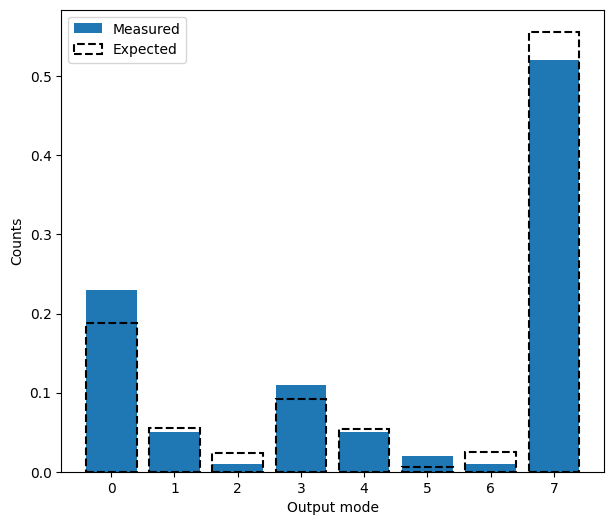

In [10]:
x = range(N)

# Convert counts to a list and normalise to total count numbers
p_calc = [counted[i] / sum(counted.values()) for i in x]

# Find expected distribution
p_exp = abs(U.T[0, :]) ** 2

plt.figure(figsize=(7, 6))
plt.bar(x, p_calc, label="Measured", alpha=1)
plt.bar(
    x,
    p_exp,
    label="Expected",
    edgecolor="Black",
    fill=False,
    linestyle="dashed",
    linewidth=1.5,
)
plt.xlabel("Output mode")
plt.ylabel("Counts")
plt.legend()
plt.show()